In [1]:
import tornado
tornado.version

'5.1.1'

In [1]:
# import pymatgen
import freud
import aiida
import ase
from aiida import orm, load_profile 
import matplotlib.pyplot as plt
from aiida.orm import QueryBuilder
from collections import Counter
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import ase
from math import pi
import numpy as np
from ase.atoms import Atoms
from ase.calculators import calculator
from ase.calculators.calculator import Calculator, kpts2ndarray
from ase import Atoms
from operator import itemgetter 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from mpl_toolkits.mplot3d import Axes3D
import random
from aiida.orm import ArrayData
from aiida.orm import TrajectoryData
from aiida.orm import StructureData
from ase import Atoms
import matplotlib
from matplotlib import cm
from matplotlib.colors import Colormap as cmap
import matplotlib.cm
import numpy as np
import rowan
# import plato.draw.fresnel
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull, convex_hull_plot_2d, SphericalVoronoi
import landlab
from landlab import VoronoiDelaunayGrid
from landlab.grid.voronoi  import simple_poly_area
from scipy.spatial import Delaunay
from landlab import RasterModelGrid
from shapely.geometry import LineString
from shapely.ops import polygonize, unary_union

In [2]:
#dataset load
len_dataset=79855
load_profile('Elena')
qb = QueryBuilder()
qb.append(orm.StructureData)


#unit normal vector of plane defined by points a, b, and c
def unit_normal(a, b, c):
    x = np.linalg.det([[1,a[1],a[2]],
         [1,b[1],b[2]],
         [1,c[1],c[2]]])
    y = np.linalg.det([[a[0],1,a[2]],
         [b[0],1,b[2]],
         [c[0],1,c[2]]])
    z = np.linalg.det([[a[0],a[1],1],
         [b[0],b[1],1],
         [c[0],c[1],1]])
    magnitude = (x**2 + y**2 + z**2)**.5
    return (x/magnitude, y/magnitude, z/magnitude)

#area of polygon poly
def poly_area(poly):
    if len(poly) < 3: # not a plane - no area
        return 0
    total = [0, 0, 0]
    N = len(poly)
    for i in range(N):
        vi1 = poly[i]
        vi2 = poly[(i+1) % N]
        prod = np.cross(vi1, vi2)
        total[0] += prod[0]
        total[1] += prod[1]
        total[2] += prod[2]
    result = np.dot(total, unit_normal(poly[0], poly[1], poly[2]))
    return abs(result/2)

In [3]:
select=10000
qb_red=random.sample(qb.all(), select)

In [20]:
frames_ase=[]
iso_q=[]
natoms=[]
for [structure_data] in qb_red:
    atoms=structure_data.get_ase()
    atoms.wrap()
    pos=atoms.get_positions()
    try:
        vor=Voronoi(pos)
    except:
        continue
    frames_ase.append(atoms)
    natom = len(structure_data.get_site_kindnames())
    natoms.append(natom)
    vol=atoms.get_volume()
    vor=Voronoi(pos)  
    polygons = {}
    for id, region_index in enumerate(vor.point_region):
        points = []
        for vertex_index in vor.regions[region_index]:
            if vertex_index != -1:  # the library uses this for infinity
                points.append(list(vor.vertices[vertex_index]))
        points.append(points[0])    
        polygons[id]=points 
    a_tot = sum(poly_area(polygons[i]) for i in range(len(polygons)))
    iso=36*pi*vol**2/(a_tot**3)
    iso_q.append(iso)
len(iso_q)

<ipython-input-20-cfa4ab3b980e>:26: RuntimeWarning: divide by zero encountered in double_scalars
  iso=36*pi*vol**2/(a_tot**3)
<ipython-input-2-826d8105069c>:20: RuntimeWarning: invalid value encountered in double_scalars
  return (x/magnitude, y/magnitude, z/magnitude)


9258

No handles with labels found to put in legend.


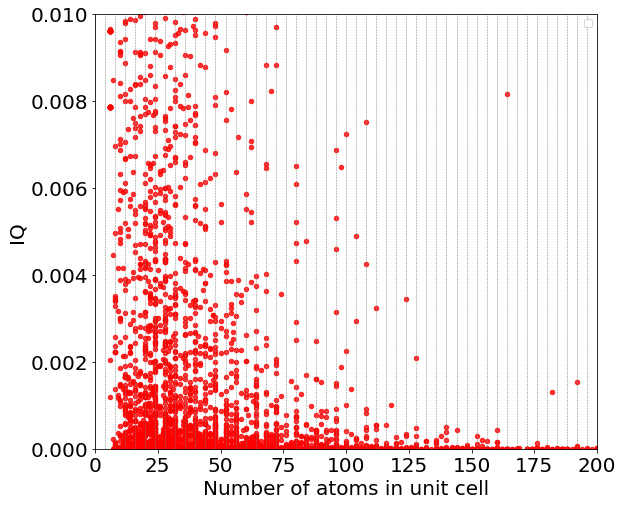

7813

In [27]:
"""Removing Nan valies and infinity"""
# for l in range(len(lista)) if np.isinf(lista[l])!=True or np.isnan(lista[l])!=True]
def remove_zeros(lista):
    idx=[l for l in range(len(lista)) if np.isinf(lista[l])!=True and np.isnan(lista[l])!=True]
    return idx

indexes=remove_zeros(iso_q)
IQ= list(itemgetter(*indexes)(iso_q))
natoms_red=list(itemgetter(*indexes)(natoms))
frames_ase=list(itemgetter(*indexes)(frames_ase))


plt.figure(figsize=(9, 8))
plt.scatter (natoms_red, IQ, s=20, alpha=0.8, c='r')
plt.legend()
plt.xlabel("Number of atoms in unit cell", size=20)
for i in range(0,200,4):
    plt.axvline(x=i, linestyle='--', c='grey', lw=0.5)
# plt.ylim(0.05, 1)
plt.ylabel("IQ", size=20)
plt.yticks(size=20)
plt.xticks(size=20)
plt.xlim(0,200)
plt.ylim(0,0.01)
# plt.savefig("element rel occ.png", bbox_inches='tight', dpi=400)
plt.show()
plt.close()

len(IQ)

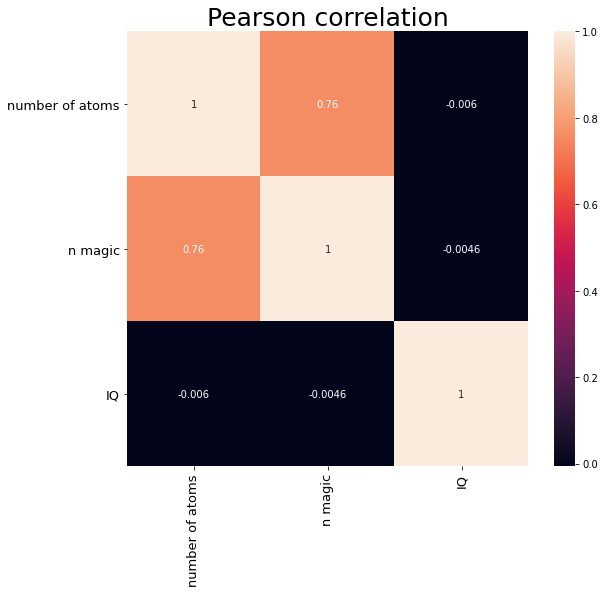

array([[<AxesSubplot:xlabel='number of atoms', ylabel='number of atoms'>,
        <AxesSubplot:xlabel='n magic', ylabel='number of atoms'>,
        <AxesSubplot:xlabel='IQ', ylabel='number of atoms'>],
       [<AxesSubplot:xlabel='number of atoms', ylabel='n magic'>,
        <AxesSubplot:xlabel='n magic', ylabel='n magic'>,
        <AxesSubplot:xlabel='IQ', ylabel='n magic'>],
       [<AxesSubplot:xlabel='number of atoms', ylabel='IQ'>,
        <AxesSubplot:xlabel='n magic', ylabel='IQ'>,
        <AxesSubplot:xlabel='IQ', ylabel='IQ'>]], dtype=object)

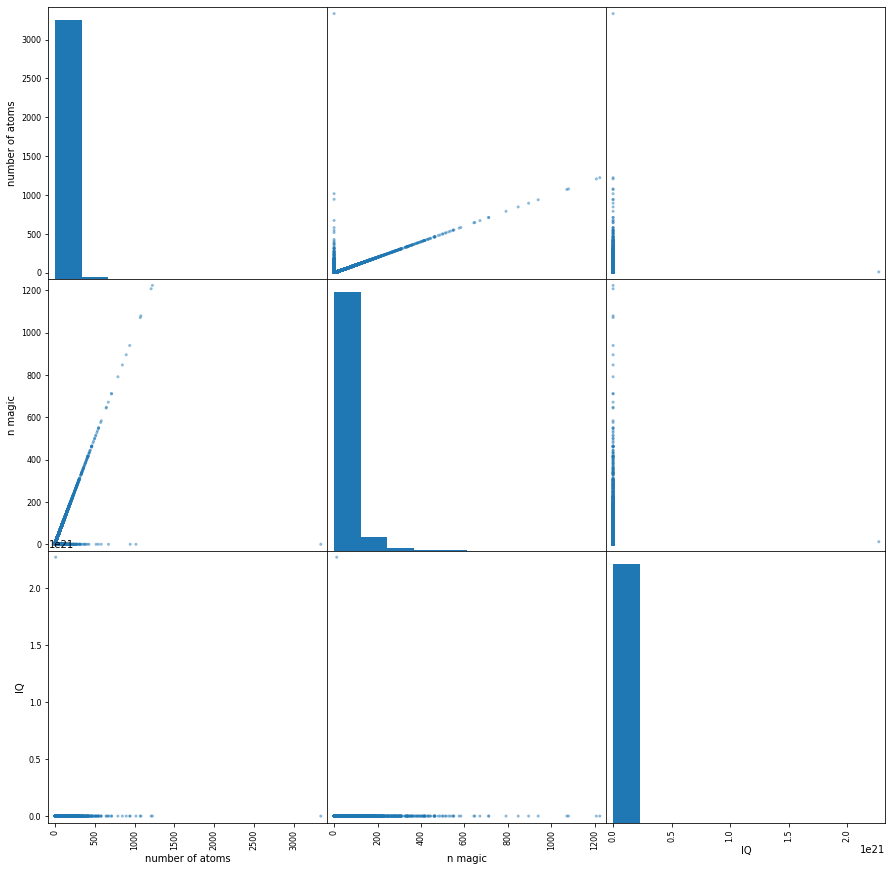

In [28]:
na_mod=natoms_red.copy()
for (i, item) in enumerate(natoms_red):
    if item %4!=0:
        na_mod[i] = 0
# print(type(volume), type(natoms), type(na_mod))   
data= {'number of atoms': natoms_red,
       'n magic':na_mod, 
       'IQ': IQ        
      }

df = pd.DataFrame(data,columns=['number of atoms','n magic', 'IQ'])
fig, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df.corr(), annot=True)
ax.tick_params(labelsize=13, direction='out')
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.title('Pearson correlation', size=25)
# plt.savefig("CM.png", bbox_inches='tight', dpi=400)
plt.show()

titles=['number of atoms','n magic', 'IQ']

scatter_matrix(df[titles], figsize=(15, 15))

In [29]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
"""Initializing StandarScaler and fitting the X_raw SOAP 2D matrix so that the standard 
normal distribution of the features has a mean of zero and a standard deviation of one """

fac=np.column_stack((natoms_red, IQ))
print(fac)
scaler=StandardScaler()
scaler.fit(fac) 
X_scaled=scaler.transform(fac)
n_components = 2

# """Normal PCA, takes more memory"""

# pca=PCA(n_components=n_components) 
# pca.fit(X_scaled)
# X_pca = pca.fit_transform(X_scaled)

"""Incremental PCA, change batch size freely"""

ipca = IncrementalPCA(n_components=n_components, batch_size=20)
# ipca.fit(X_scaled)
X_ipca = ipca.fit_transform(X_scaled)

[[  6.40000000e+01   1.54433657e-05]
 [  1.80000000e+01   4.23978050e-01]
 [  2.40000000e+01   1.87190548e-02]
 ..., 
 [  8.00000000e+00   6.12834147e-01]
 [  4.00000000e+01   3.19943742e-06]
 [  9.80000000e+01   2.32731479e-08]]


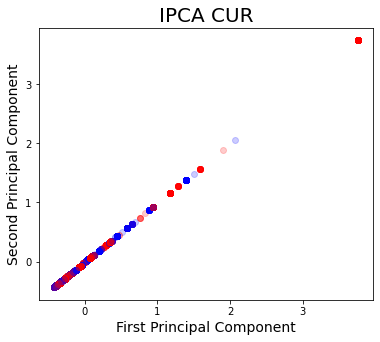

In [32]:
fig,ax=plt.subplots(figsize=(6,5))

for frame in frames_ase:
    natoms=(len(frame))
#     print(start, natoms)
    if natoms%4==0:
        ax.scatter(X_ipca[natoms, 0], X_ipca[natoms, 1],c='r', alpha=0.2)
    else:
        ax.scatter(X_ipca[natoms , 0], X_ipca[natoms, 1], c='b', alpha=0.2)

        # plt.savefig('PCA_2.png', bbox_inches= 'tight', dpi=400 )

plt.title("IPCA CUR",fontsize=20)
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
# plt.savefig('IPCA_geometric_mixed_db', bbox_inches= 'tight', dpi=700 )
plt.show()
plt.close()